This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

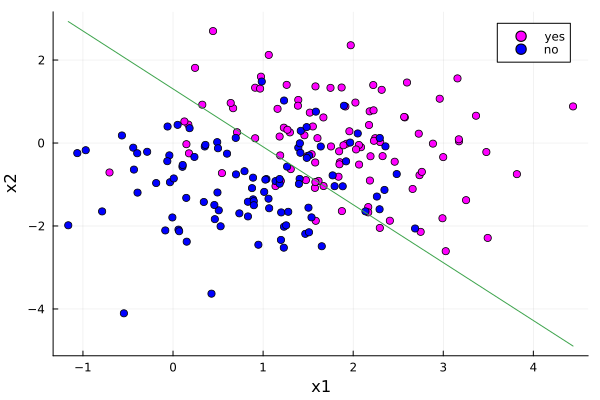

In [18]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

function svm2(A, y; C=100)
    (m, n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0)  # slack variables

    @NLconstraint(model, sum(β[i]^2 for i in 1:n) == 1)
    for i in 1:m
        @constraint(model, y[i] * (β' * A[i, :]) >= 1 - s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)

    @objective(model, Min, sum(β[i]^2 for i in 1:n))

    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

# two-class data
df = CSV.read("two-class-data.csv", DataFrame)

fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

β = svm2(A, y; C=99)         # obtain the model parameters

y_hat = zeros(length(y))    # Initialize y_hat
misclassification = 0

for i in 1:length(y)
    y_hat[i] = dot(β, A[i, :])
    if y_hat[i] * y[i] < 0
        misclassification += 1
    end
end

misclassification_rate = misclassification / length(y)
println("Misclassification rate: ", misclassification_rate)

f(x) = (-β[1] - β[2]*x) / β[3]  # decision boundary helper function

yes = findall(x -> x == 1, y)    # indices for the +1 class
no = findall(x -> x == -1, y)    # indices for the -1 class

# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes")
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", xlabel="x1", ylabel="x2")

The tradeoff for using a large value of C is that C is functionally a tuning paramter. Too little C will restrict the "slack variables" (epsilon), and too large C will, in the words of ISLR "become more tolerant of violations to the margin, and so the margin will widen". This just means that more slack variables will be allowed outside of our given margin, essentially allowing a lot more unecessary variables. You need to have a certain amount of C because restricting out the budget for violations can severly restrict a dataset, but allowing too much C will cause the margin to widen to the point that the data doesnt fit properly, and we could recieve a more biased final classifier.